# SuperstoreSalesPredictor

This Jupyter Notebook analyzes Superstore sales data made available on [Kaggle](https://www.kaggle.com/jr2ngb/superstore-data).  This machine learning sales predictor uses time series analysis to precict a year of sales.  It was created for INFO 659 at Drexel University for the Fall 2021-2022 Quarter.  This `.ipynb` file -- and all relevant documentation -- is available on [Github](https://github.com/zachcarlson/SuperstoreSalesPredictor)

The `SuperstoreSalesPredictor` project was coded in both Python and R.

## Group Information

### Team Members:

- Zach Carlson, zc378@drexel.edu
- Sarah Haley, slh54@drexel.edu
- Nancy Melucci, njm99@drexel.edu

## Importing Data and Preprocessing
### Import Packages, fonts, and functions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
FILE_PATH = "/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/superstore_dataset2011-2015.csv" #if using google colab
# FILE_PATH = "./data/superstore_dataset2011-2015.csv" #if using Jupyter notebook

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
pd.set_option('max_columns', 25) #some columns will be truncated otherwise, setting to number of columns in sales
sns.set_style("ticks")
sns.set(font_scale = 1.5)

In [4]:
font = {'family': 'sans-serif',
        'size'  : 15}

matplotlib.rc('font', **font)

### Import Data and Pre-processing

In [5]:
sales_raw = pd.read_csv(FILE_PATH, 
                    encoding = "latin")

In [6]:
sales_raw.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,Algeria,NaN,Africa,Africa,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,Hungary,NaN,EMEA,EMEA,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,Sweden,NaN,EU,North,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,Australia,NaN,APAC,Oceania,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


In [7]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [8]:
sales_raw.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
count,51290.00000,9994.000000,51290.000000,51290.000000,51290.000000,51290.000000,51290.000000
mean,25645.50000,55190.379428,246.490581,3.476545,0.142908,28.610982,26.375915
std,14806.29199,32063.693350,487.565361,2.278766,0.212280,174.340972,57.296804
min,1.00000,1040.000000,0.444000,1.000000,0.000000,-6599.978000,0.000000
25%,12823.25000,23223.000000,30.758625,2.000000,0.000000,0.000000,2.610000
50%,25645.50000,56430.500000,85.053000,3.000000,0.000000,9.240000,7.790000
75%,38467.75000,90008.000000,251.053200,5.000000,0.200000,36.810000,24.450000
max,51290.00000,99301.000000,22638.480000,14.000000,0.850000,8399.976000,933.570000


#### Observations:

- There are 51,290 instances with 24 features.
- Dates are in `DD/MM/YYYY` format.
- Features are mostly `object`, with five `float64` and two `int64` features.  Datetime columns need to be converted accordingly.
- There are 41,296 missing values from `Postal Code`.  This is because the `Postal Code` is only present for U.S. purchases.

We'll save a copy of `sales_raw` in case we want to utilize `Postal Code` later.  However, for sales-focused prediction, it won't be necessary:

In [9]:
sales = sales_raw.copy()
sales = sales.drop("Postal Code", axis = 1) #axis=1 for column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Market          51290 non-null  object 
 12  Region          51290 non-null  object 
 13  Product ID      51290 non-null  object 
 14  Category        51290 non-null  object 
 15  Sub-Category    51290 non-null  object 
 16  Product Name    51290 non-null  object 
 17  Sales           51290 non-null 

In [10]:
#convert datetime columns to datetime objects
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  datetime64[ns]
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Market          51290 non-null  object        
 12  Region          51290 non-null  object        
 13  Product ID      51290 non-null  object        
 14  Category        51290 non-null  object        
 15  Su

In [11]:
#Get only order date, sales, and profit
sales = sales.loc[:, ["Order Date", "Sales", "Profit"]]

#Set date column to index
sales.set_index('Order Date', inplace = True)

In [12]:
#confirm we have a Datetime series object
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51290 entries, 2011-01-01 to 2014-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   51290 non-null  float64
 1   Profit  51290 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB
None


## EDA

### Raw Visualization

Let's start by visualizing the `Sales` and `Profit` from 2011-2015:

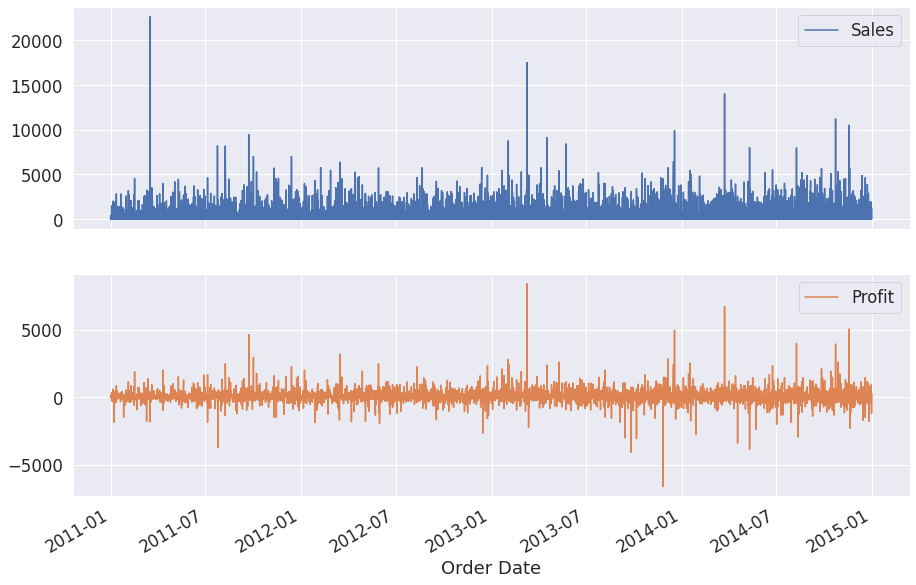

In [13]:
sales.plot(subplots = True)
plt.gcf().set_size_inches(15, 10)
plt.show()

Let's see how the data compares year to year by overlapping the time series data:

**Observations:**

- Raw visualizations and yearly overlap are hard to read.  More will need to be done to improve it.  Optimizing frequency of the time series period and working with rolling averages may help.

### Frequency Optimization

It is pretty challenging to see anything on these plots.  At the very least, let's consolidate `Sales` and `Profits` data from each day:

In [14]:
sales = sales.groupby("Order Date").sum()
sales

,Sales,Profit
Order Date,,
2011-01-01,808.56300,198.87300
2011-01-02,2455.67000,603.47360
2011-01-03,12565.76630,1905.15390
2011-01-04,2582.80100,-308.78740
2011-01-06,11480.49270,2460.25360
...,...,...
2014-12-27,13421.26376,-916.64004
2014-12-28,1647.17400,81.06380
2014-12-29,25109.28878,2046.20678


In [15]:
#Create empty dataframe to store yearly data
sales_by_year = pd.DataFrame()

for year in ["2011", "2012", "2013", "2014"]:
  temp_year = sales.loc[year, ["Sales"]].reset_index(drop = True)
  temp_year.rename(columns={"Sales": year}, inplace = True)
  sales_by_year = pd.concat([sales_by_year, temp_year], axis=1)

sales_by_year

,2011,2012,2013,2014
0,808.5630,1655.25490,9369.15300,3614.03450
1,2455.6700,3912.28452,3303.96156,866.49600
2,12565.7663,510.89580,6597.06804,2913.32268
3,2582.8010,3648.94540,5679.58500,12109.78130
4,11480.4927,9042.42550,11486.83880,10075.29040
...,...,...,...,...
356,NaN,4823.09400,3553.03630,13421.26376
357,NaN,10668.58440,426.56000,1647.17400
358,NaN,NaN,14292.38000,25109.28878
359,NaN,NaN,14176.72090,16831.61480


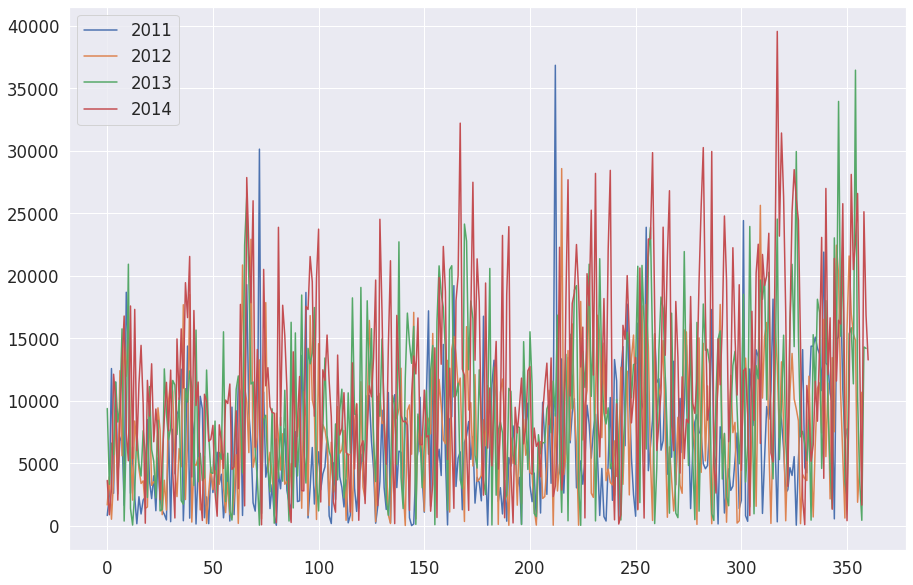

In [16]:
sales_by_year.plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

Plotting the `sales` data using a daily frequency `D` still is hard to understand.  Setting the frequency to monthly `M` greatly improves readability.  We'll also include the yearly frequency `Y`:

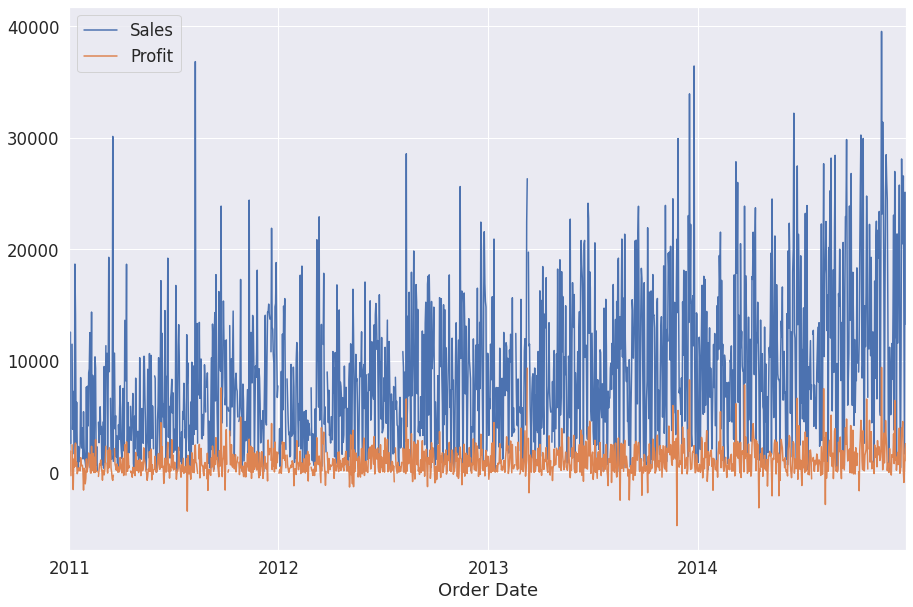

In [17]:
daily_sales = sales.asfreq('D')
daily_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

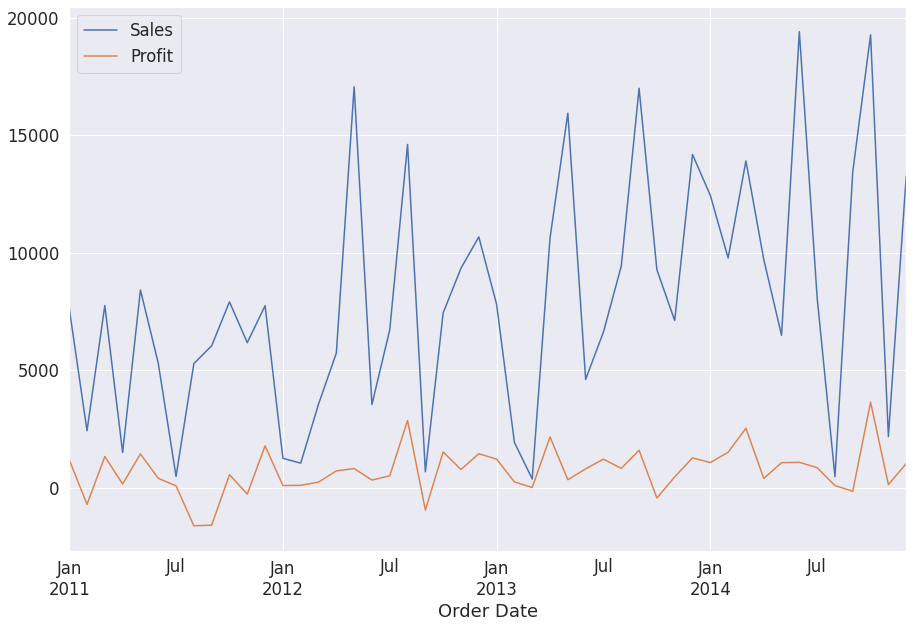

In [18]:
monthly_sales = sales.asfreq('M')
monthly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

In [19]:
yearly_sales = sales.asfreq('Y')
yearly_sales

,Sales,Profit
Order Date,,
2011-12-31,7740.6630,1777.2461
2012-12-31,10668.5844,1441.0186
2013-12-31,14176.7209,1265.2001
2014-12-31,13257.9543,1020.1708


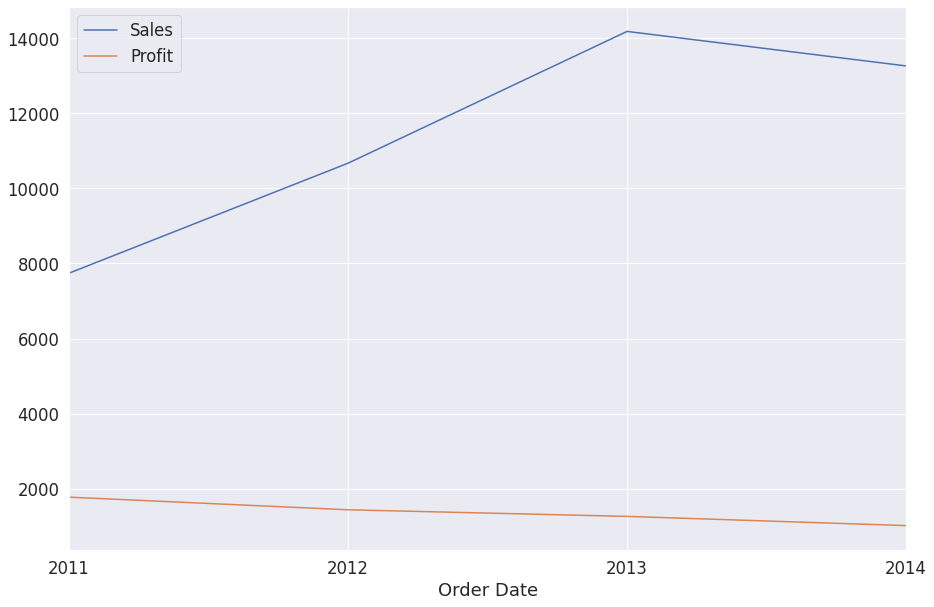

In [20]:
yearly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

Let's revisit the year-by-year overlap figure by with the monthly data instead:

In [21]:
#Create empty dataframe to store yearly data
sales_by_year_by_month = pd.DataFrame()

for year in ["2011", "2012", "2013", "2014"]:
  temp_year = monthly_sales.loc[year, ["Sales"]].reset_index(drop = True)
  temp_year.rename(columns={"Sales": year}, inplace = True)
  sales_by_year_by_month = pd.concat([sales_by_year_by_month, temp_year], axis=1)

sales_by_year_by_month

,2011,2012,2013,2014
0,7642.58500,1245.6630,7798.75720,12439.85080
1,2418.31700,1040.4460,1922.29300,9769.57336
2,7748.07600,3551.7640,367.57800,13905.25600
3,1493.78400,5722.8570,10620.80090,9716.07954
4,8409.74388,17059.5785,15936.41300,6481.32560
5,5298.06040,3535.9790,4605.03000,19407.16738
6,475.95360,6716.2685,6623.87250,8073.05200
7,5277.45210,14604.5829,9422.39850,462.21000
8,6035.16290,668.9520,16996.50382,13452.24002
9,7905.44000,7437.6325,9274.14244,19270.83944


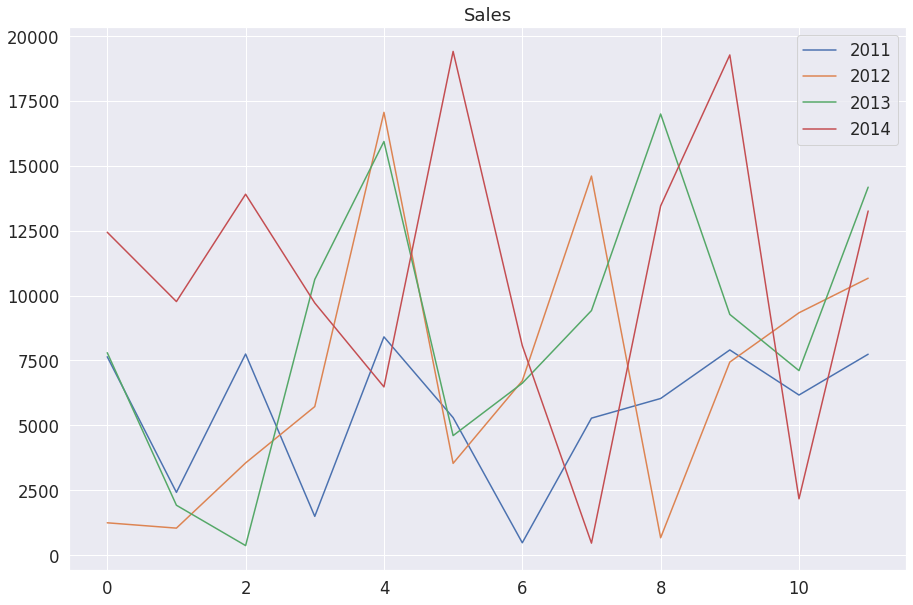

In [22]:
sales_by_year_by_month.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales")
plt.show()

**Observations:**
- There do appear to be yearly spikes around Month 4-5 and Month 8.  These correspond to the 5-6th and 9th months of the year due to how Python deals with indices, which are **May-June** and **September**.  
- This may be due to the start of buying things for summer months as well as school supplies shopping.
- The frequency of month appears best, with daily being too noisy and yearly being too simple.  However, all graphs are jagged.  It's possible the rolling average might be the best strategy here.

### Rolling Averages

This data is still quite difficult to visualize.  It might be best to do a rolling average.  Let's plot the daily sales and a 7-day rolling average:

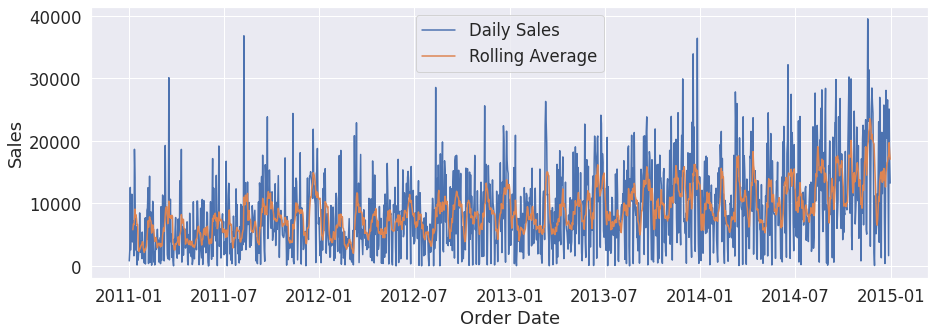

In [23]:
sales['7D_sales'] = sales.Sales.rolling(7).mean()
sales['7D_profit'] = sales.Profit.rolling(7).mean()
plt.gcf().set_size_inches(15, 5)
sns.lineplot(x = sales.index, y = 'Sales', data = sales, label = 'Daily Sales')
sns.lineplot(x = sales.index, y = '7D_sales', data = sales, label = 'Rolling Average', palette=['r'])

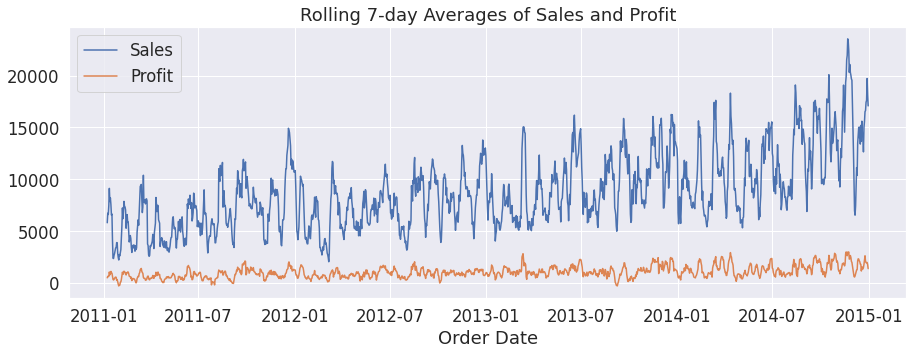

In [24]:
plt.gcf().set_size_inches(15, 5)
sns.lineplot(x = sales.index, y = '7D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '7D_profit', data = sales, label = 'Profit')

plt.title("Rolling 7-day Averages of Sales and Profit")
plt.ylabel("")
plt.show()

Let's see if a 30-day rolling average improves the readability:

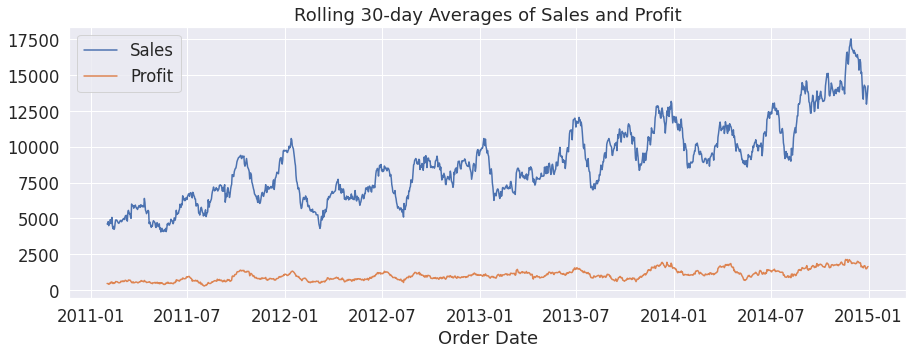

In [25]:
sales['30D_sales'] = sales.Sales.rolling(30).mean()
sales['30D_profit'] = sales.Profit.rolling(30).mean()

sns.lineplot(x = sales.index, y = '30D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '30D_profit', data = sales, label = 'Profit')

plt.title("Rolling 30-day Averages of Sales and Profit")
plt.gcf().set_size_inches(15, 5)
plt.ylabel("")
plt.show()

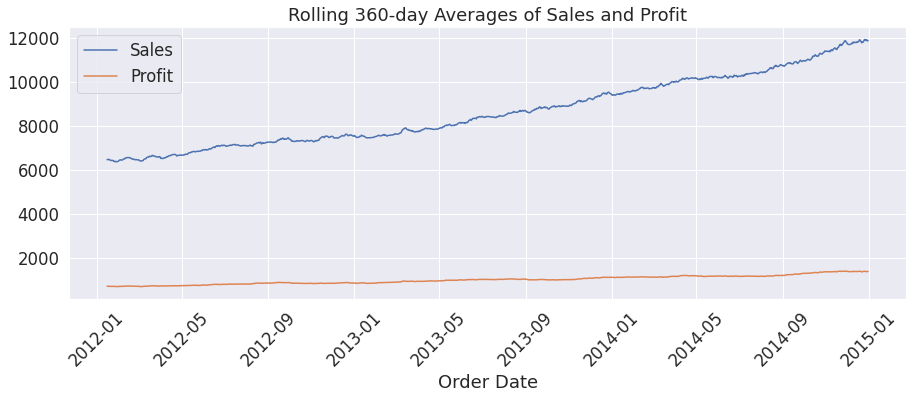

In [26]:
sales['360D_sales'] = sales.Sales.rolling(365).mean()
sales['360D_profit'] = sales.Profit.rolling(365).mean()

sns.lineplot(x = sales.index, y = '360D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '360D_profit', data = sales, label = 'Profit')

plt.title("Rolling 360-day Averages of Sales and Profit")
plt.gcf().set_size_inches(15, 5)
plt.ylabel("")
plt.xticks(rotation=45)
plt.show()

It may appear that profit is stagnant over this time period, however when splitting the data into subplots, it's clear that profit is increasing, however not nearly at the scale of sales:

Text(0, 0.5, '')

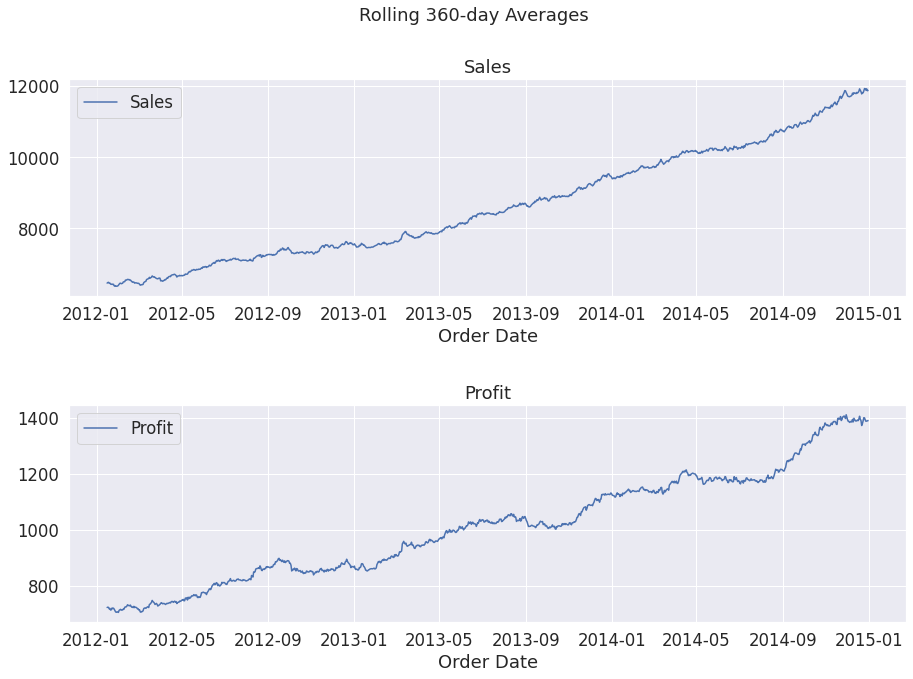

In [27]:
fig, axes = plt.subplots(2, 1)

sns.lineplot(ax = axes[0], x = sales.index, y = '360D_sales', data = sales, label = 'Sales', )
sns.lineplot(ax = axes[1], x = sales.index, y = '360D_profit', data = sales, label = 'Profit', palette='r')

fig.suptitle('Rolling 360-day Averages')
plt.gcf().set_size_inches(15, 10)
plt.subplots_adjust(hspace=0.5)
axes[0].set_title('Sales')
axes[1].set_title('Profit')
axes[0].set_ylabel("")
axes[1].set_ylabel("")

It is useful to see the distribution of the rolling average to see how volatile the sales time series actually is:

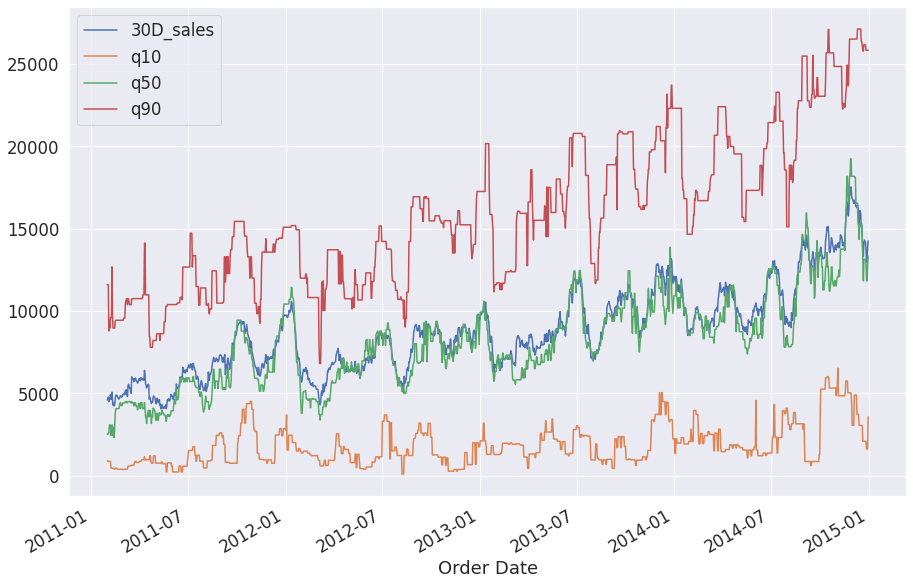

In [42]:
#get subset of data
sales_subset = sales.loc[:,["Sales", "30D_sales"]]

#create rolling average
rolling = sales_subset.Sales.rolling(30)

#calculate quantiles
sales_subset['q10'] = rolling.quantile(0.1).to_frame('q10')
sales_subset['q50'] = rolling.quantile(0.5).to_frame('q50')
sales_subset['q90'] = rolling.quantile(0.9).to_frame('q90')

#plot data
sales_subset[["30D_sales", "q10", "q50", "q90"]].plot()
plt.gcf().set_size_inches(15, 10)
plt.show()

Let's create one summary figure with subplots of all the different rolling averages from above:

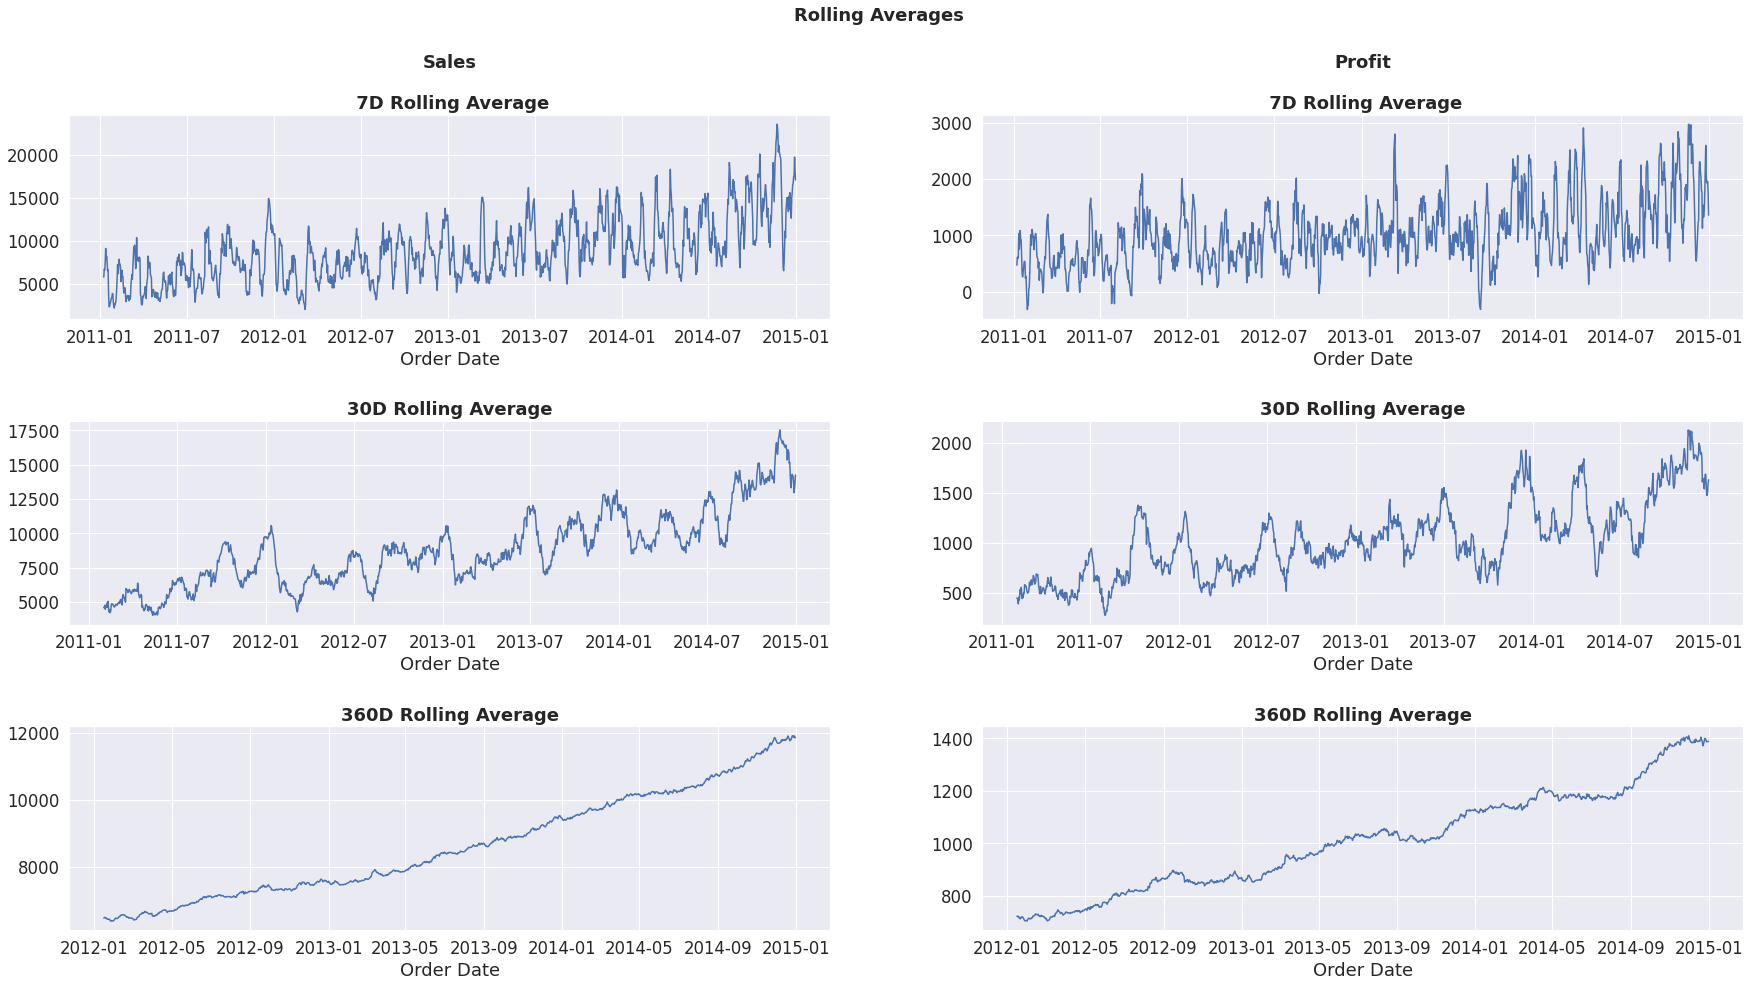

In [28]:
#plot sales percentage change
fig, axes = plt.subplots(3, 2)

sns.lineplot(ax = axes[0, 0], x = sales.index, y = '7D_sales', data = sales)
sns.lineplot(ax = axes[0, 1], x = sales.index, y = '7D_profit', data = sales)
sns.lineplot(ax = axes[1, 0], x = sales.index, y = '30D_sales', data = sales)
sns.lineplot(ax = axes[1, 1], x = sales.index, y = '30D_profit', data = sales)
sns.lineplot(ax = axes[2, 0], x = sales.index, y = '360D_sales', data = sales)
sns.lineplot(ax = axes[2, 1], x = sales.index, y = '360D_profit', data = sales)

fig.suptitle('Rolling Averages', weight='bold')
axes[0,0].set_title("Sales\n\n 7D Rolling Average", weight='bold')
axes[0,1].set_title("Profit\n\n 7D Rolling Average", weight='bold')
axes[1,0].set_title("30D Rolling Average", weight='bold')
axes[1,1].set_title("30D Rolling Average", weight='bold')
axes[2,0].set_title("360D Rolling Average", weight='bold')
axes[2,1].set_title("360D Rolling Average", weight='bold')
axes[0,0].set_ylabel("")
axes[0,1].set_ylabel("")
axes[1,0].set_ylabel("")
axes[1,1].set_ylabel("")
axes[2,0].set_ylabel("")
axes[2,1].set_ylabel("")
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)

**Observations:**

- Out of all the visualization techniques, the 30-day rolling average is the best.  We'll be using that going forward.
- **The rolling 360-day average of sales and profit clearly show an increase in sales and profit overtime, however sales is increase at a scale of almost 10x more.**

### Rolling Average Percent Change

Let's look at the monthly and yearly percent changes in sales and profit values:

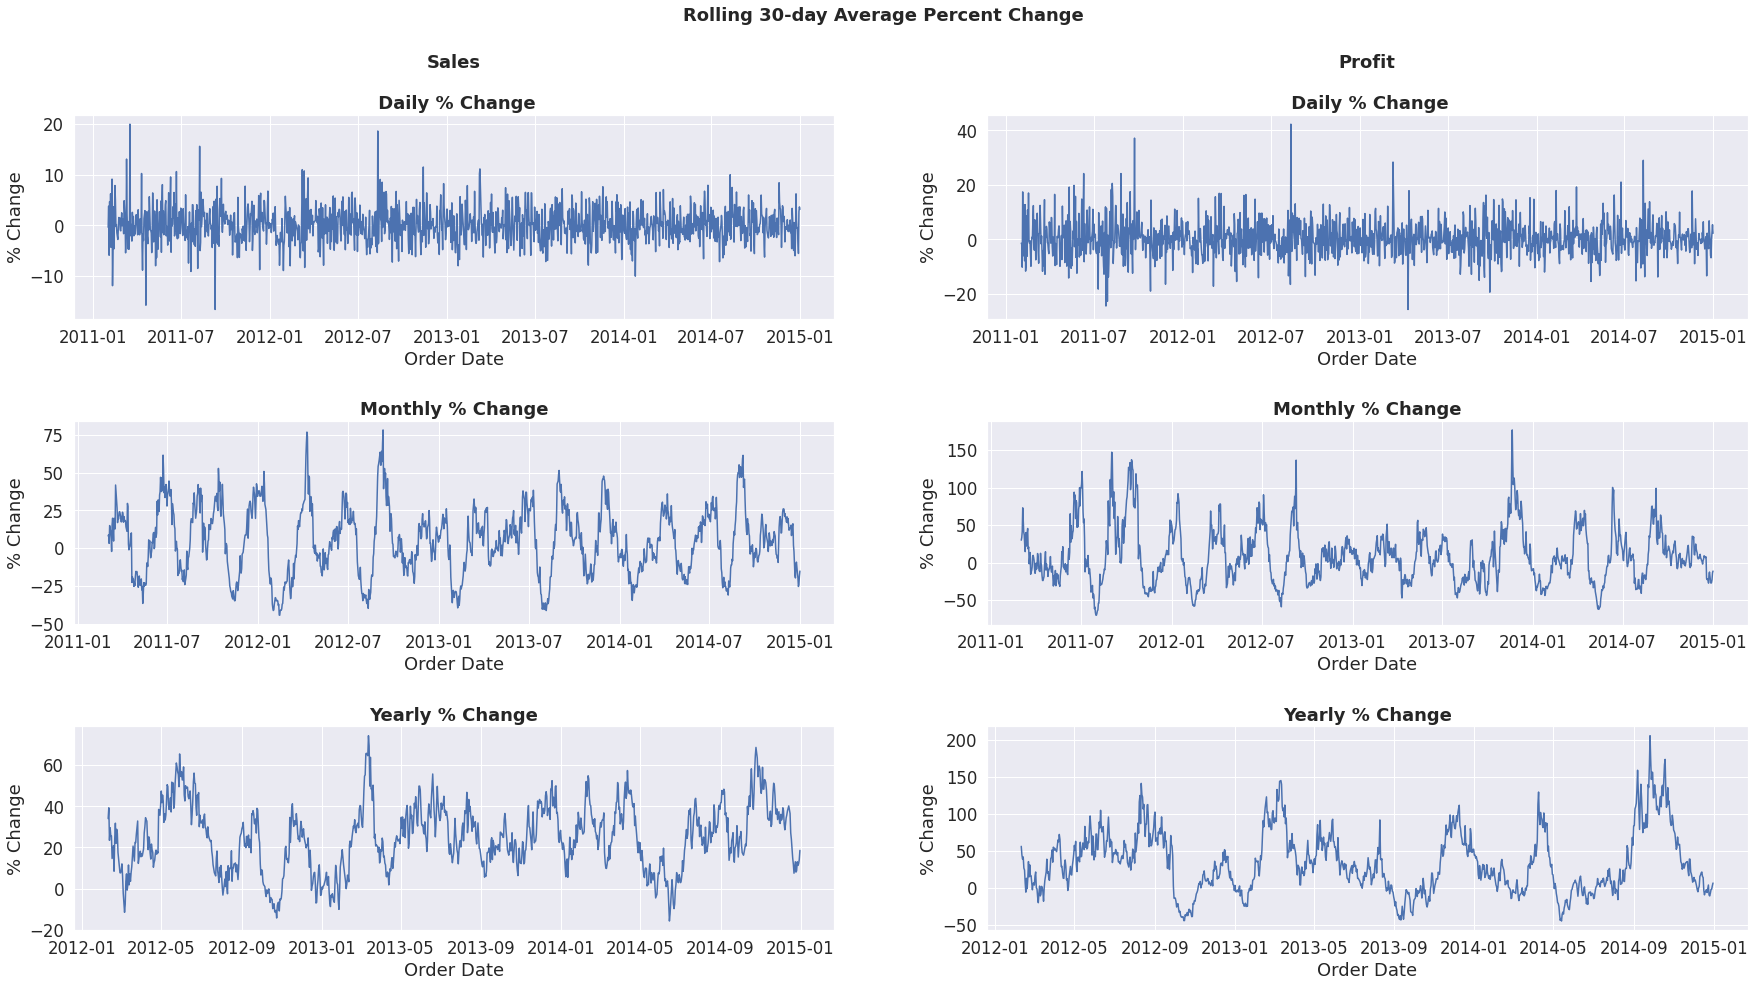

In [29]:
#sales
sales['30D_sales_daily'] = sales['30D_sales'].pct_change(periods = 1).mul(100) #daily
sales['30D_sales_monthly'] = sales['30D_sales'].pct_change(periods = 30).mul(100) #monthly
sales['30D_sales_yearly'] = sales['30D_sales'].pct_change(periods = 360).mul(100) #yearly

#profit
sales['30D_profit_daily'] = sales['30D_profit'].pct_change(periods = 1).mul(100) #daily
sales['30D_profit_monthly'] = sales['30D_profit'].pct_change(periods = 30).mul(100) #monthly
sales['30D_profit_yearly'] = sales['30D_profit'].pct_change(periods = 360).mul(100) #yearly

#plot sales percentage change
fig, axes = plt.subplots(3, 2)

sns.lineplot(ax = axes[0, 0], x = sales.index, y = '30D_sales_daily', data = sales)
sns.lineplot(ax = axes[0, 1], x = sales.index, y = '30D_profit_daily', data = sales)
sns.lineplot(ax = axes[1, 0], x = sales.index, y = '30D_sales_monthly', data = sales)
sns.lineplot(ax = axes[1, 1], x = sales.index, y = '30D_profit_monthly', data = sales)
sns.lineplot(ax = axes[2, 0], x = sales.index, y = '30D_sales_yearly', data = sales)
sns.lineplot(ax = axes[2, 1], x = sales.index, y = '30D_profit_yearly', data = sales)

fig.suptitle('Rolling 30-day Average Percent Change', weight='bold')
axes[0,0].set_title("Sales\n\n Daily % Change", weight='bold')
axes[0,1].set_title("Profit\n\n Daily % Change", weight='bold')
axes[1,0].set_title("Monthly % Change", weight='bold')
axes[1,1].set_title("Monthly % Change", weight='bold')
axes[2,0].set_title("Yearly % Change", weight='bold')
axes[2,1].set_title("Yearly % Change", weight='bold')
axes[0,0].set_ylabel("% Change")
axes[0,1].set_ylabel("% Change")
axes[1,0].set_ylabel("% Change")
axes[1,1].set_ylabel("% Change")
axes[2,0].set_ylabel("% Change")
axes[2,1].set_ylabel("% Change")
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)

**Observations:**

- The day-to-day percent changes in sales are pretty constant around zero.
- The month-to-month and year-to-year percent changes in sales and profit show clear time-based oscillations.

### Correlation Analysis

Looking at the rolling averages, there is clearly some correlation between sales and profit:

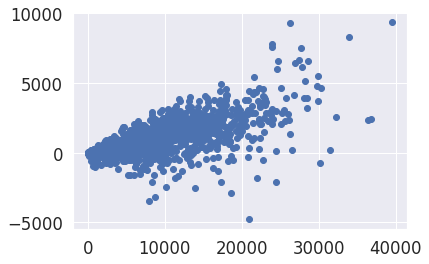

In [50]:
plt.scatter(sales["Sales"], sales["Profit"])
plt.show()

In [54]:
correlation = sales["Sales"].corr(sales["Profit"])
correlation_7D = sales["7D_sales"].corr(sales["7D_profit"])
correlation_30D = sales["30D_sales"].corr(sales["30D_profit"])
correlation_360D = sales["360D_sales"].corr(sales["360D_profit"])

print("Raw data correlation is:", correlation)
print("7D rolling average correlation is:", correlation_7D)
print("30D rolling average correlation is:", correlation_30D)
print("360D rolling average correlation is:", correlation_360D)

Raw data correlation is: 0.6495587604092662
7D rolling average correlation is: 0.7994820195002961
30D rolling average correlation is: 0.8868838776718004
360D rolling average correlation is: 0.9886352035626841


**Observations:**
- As the rolling average gets larger, the correlation between sales and profits gets stronger.

## Autocorrelation, Autoregression, and ARIMA

### Autocorrelation

We'll do an autocorrelation analysis on the Sales and Profit time series using different rolling averages:

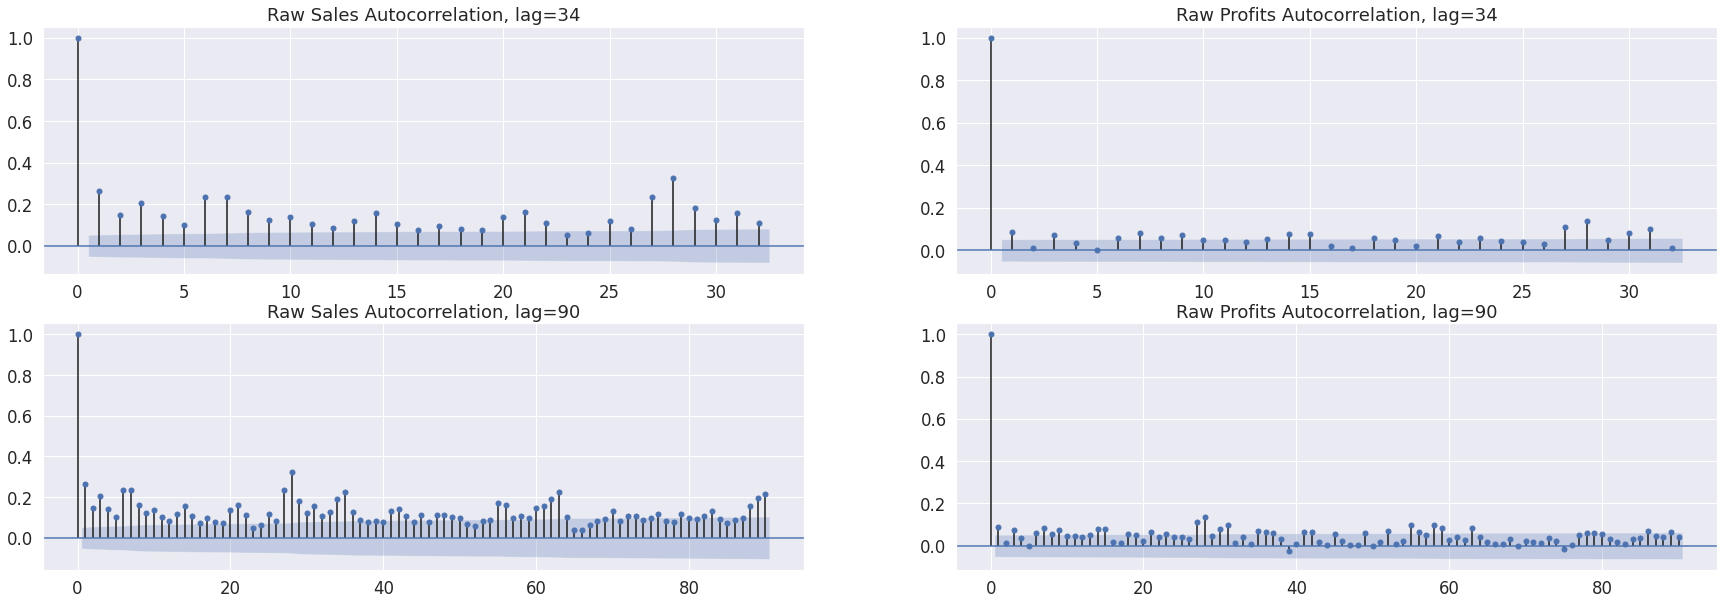

In [113]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(2,2)

#create plot
plot_acf(sales["Sales"], ax=ax[0, 0], title="Raw Sales Autocorrelation, lag=34");
plot_acf(sales["Profit"], ax=ax[0, 1], title="Raw Profits Autocorrelation, lag=34");
plot_acf(sales["Sales"], lags=90, ax=ax[1, 0], title="Raw Sales Autocorrelation, lag=90");
plot_acf(sales["Profit"], lags=90, ax=ax[1, 1], title="Raw Profits Autocorrelation, lag=90");

#visuals
fig.suptitle('Rolling 30-day Average Percent Change', weight='bold')
plt.gcf().set_size_inches(30, 10)
plt.show()

Now let's look at the autocorrelation when using the 30D rolling average data.  We'll need to use `.dropna()` to remove the missing values:

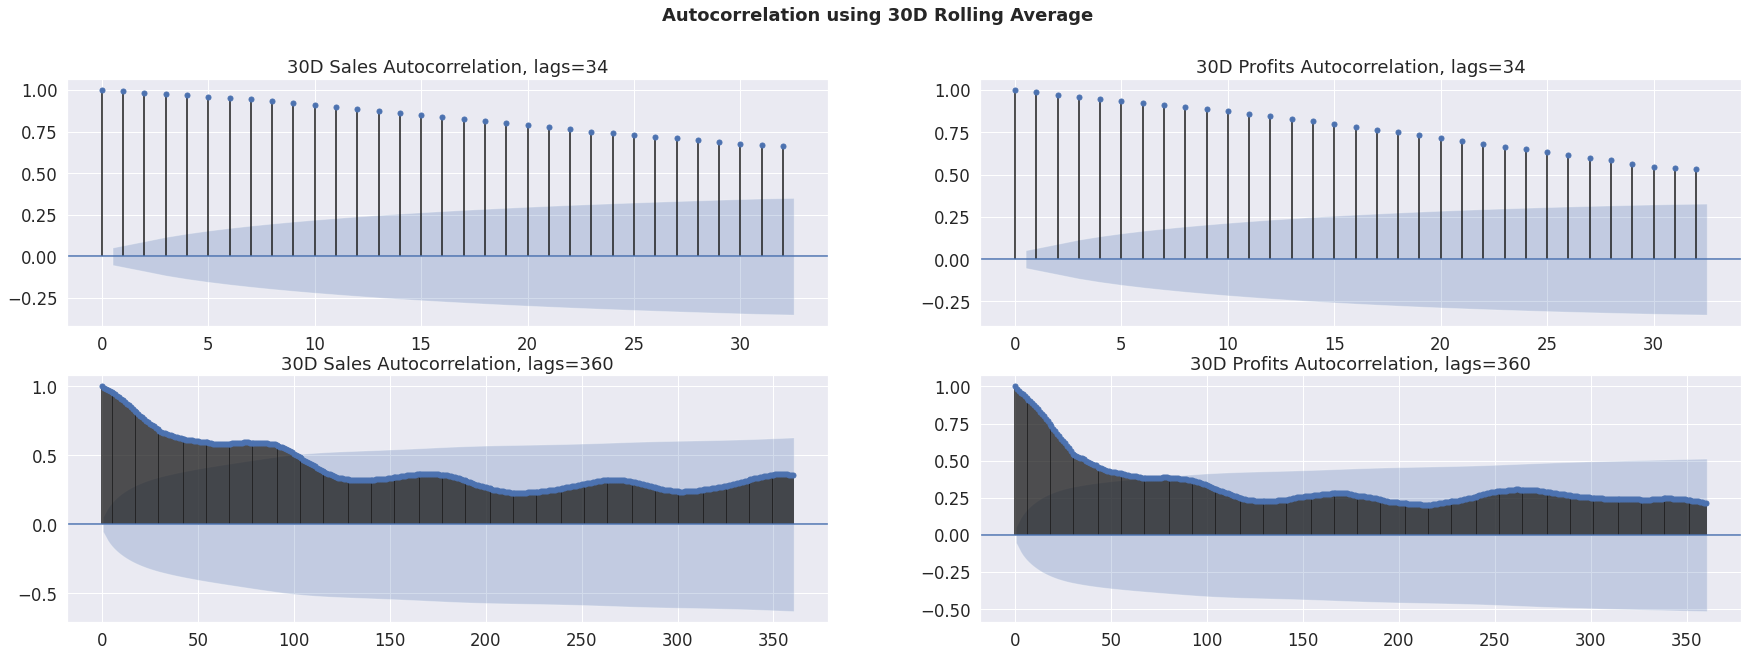

In [117]:
fig, ax = plt.subplots(2,2)

#create plot
plot_acf(sales["30D_sales"].dropna(), ax=ax[0, 0], title="30D Sales Autocorrelation, lags=34");
plot_acf(sales["30D_profit"].dropna(), ax=ax[0, 1], title="30D Profits Autocorrelation, lags=34");
plot_acf(sales["30D_sales"].dropna(), lags=360, ax=ax[1, 0], title="30D Sales Autocorrelation, lags=360");
plot_acf(sales["30D_profit"].dropna(), lags=360, ax=ax[1, 1], title="30D Profits Autocorrelation, lags=360");

#visuals
fig.suptitle('Autocorrelation using 30D Rolling Average', weight='bold')
plt.gcf().set_size_inches(30, 10)
plt.show()

In [81]:
sales_subset

,Sales,30D_sales,q10,q50,q90
Order Date,,,,,
2011-01-01,808.56300,NaN,NaN,NaN,NaN
2011-01-02,2455.67000,NaN,NaN,NaN,NaN
2011-01-03,12565.76630,NaN,NaN,NaN,NaN
2011-01-04,2582.80100,NaN,NaN,NaN,NaN
2011-01-06,11480.49270,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2014-12-27,13421.26376,13734.575018,2083.6195,12752.39133,25835.00553
2014-12-28,1647.17400,12974.698671,1613.3830,11825.86590,25835.00553
2014-12-29,25109.28878,13327.916263,1613.3830,11825.86590,25835.00553


## Conclusions and Summary